## Github issue

Hello,

I am trying to use the method on simple data frames,

A: A data frame with two columns corresponding to ligand and receptor expression across N locations
B: A data frame with xy-coordinates of the N spatial locations

No cell types are assigned. Just trying to do an overall analysis.

Can you help me do that without going through SpatialDM and other required hoops?

Thank you so much in advance!


## Action 
I will try to minimize the dependence on existing python imports 

In [33]:
!which python

/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/bin/python


In [50]:
!pwd

/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/tutorial


In [267]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.signal import find_peaks

In [53]:
code_path = "/n/fs/ragr-research/users/hirak/Projects/copulacci/simplified_method/"

In [52]:
import sys

In [55]:
sys.path.append(code_path)

In [3]:
n = 100  # you can change this
coords = np.random.uniform(low=0, high=10, size=(n, 2))
loc_df = pd.DataFrame(
    coords, 
    columns = ['x', 'y']
)

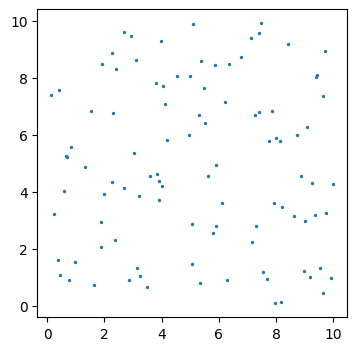

In [8]:
plt.figure(figsize=(4,4))
plt.scatter(loc_df.x, loc_df.y, s=2)
plt.show()

## Make spatial Graph.

In [61]:
import numpy as np
from scipy.spatial import KDTree, distance_matrix
from scipy.sparse import lil_matrix
from kneed import KneeLocator  # install with: pip install kneed

def find_cutoff_radius(coords, plot=False):
    """
    Find a good cutoff radius for d-ball neighbors using a knee-finding algorithm.
    
    Parameters:
        coords (np.ndarray): N x 2 coordinate array
        plot (bool): If True, plot the sorted distances and detected knee point

    Returns:
        float: estimated cutoff radius
    """
    n = coords.shape[0]
    
    # Compute upper-triangle pairwise distances
    dists = distance_matrix(coords, coords)
    dists = dists[np.triu_indices(n, k=1)]
    sorted_dists = np.sort(dists)

    # Knee detection
    x = np.arange(len(sorted_dists))
    kneedle = KneeLocator(x, sorted_dists, curve="concave", direction="increasing")
    
    if kneedle.knee is not None:
        cutoff_radius = sorted_dists[kneedle.knee]
    else:
        cutoff_radius = np.percentile(sorted_dists, 5)

    # Optional plotting
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(sorted_dists, label='Sorted distances')
        if kneedle.knee is not None:
            plt.axvline(x=kneedle.knee, color='red', linestyle='--', label=f'Knee at {cutoff_radius:.2f}')
        plt.xlabel("Index")
        plt.ylabel("Distance")
        plt.title("Knee Detection for Cutoff Radius")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return cutoff_radius


def spatial_neighbors(coords, n_rings=1, coord_type='grid', radius=None):
    """
    Compute spatial neighbors using either grid or generic coordinates.

    Parameters:
        coords (np.ndarray): N x 2 array of 2D spatial coordinates
        n_rings (int): Number of rings (for 'grid') or ignored if 'generic'
        coord_type (str): 'grid' or 'generic'
        radius (float): radius for ball query (only for generic)

    Returns:
        scipy.sparse.csr_matrix: Sparse matrix of Euclidean distances
    """
    n = coords.shape[0]
    mat = lil_matrix((n, n))
    
    kdt = KDTree(coords)
    
    if coord_type == 'grid':
        # Grid layout: approximate by kNN
        dists, indices = kdt.query(coords, k=(8 * n_rings + 1))
        for i in range(n):
            for j, dist in zip(indices[i], dists[i]):
                if i != j:
                    mat[i, j] = dist

    elif coord_type == 'generic':
        if radius is None:
            radius = find_cutoff_radius(coords)
        
        neighbors = kdt.query_ball_point(coords, r=radius)
        for i, nbrs in enumerate(neighbors):
            for j in nbrs:
                if i != j:
                    dist = np.linalg.norm(coords[i] - coords[j])
                    mat[i, j] = dist

    return mat.tocsr()


def get_edge_indices(mat,self_loops=False):
    """
    Extract unique directed edge indices from sparse graph.

    Parameters:
        mat (scipy.sparse matrix): adjacency matrix

    Returns:
        edges (np.ndarray): shape (n_edges, 2), where each row is (i, j)
    """
    G = mat.tocoo()
    if self_loops:
        mask = G.row <= G.col
    else:
        mask = G.row < G.col

    edges = np.vstack((G.row[mask], G.col[mask])).T
    return edges

In [40]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_spatial_graph(coords, mat):
    """
    Plot spatial graph edges and node positions.

    Parameters:
        coords (np.ndarray): N x 2 array of coordinates
        mat (scipy.sparse matrix): Sparse matrix of distances (edges)
    """
    plt.figure(figsize=(4, 4))

    # Plot edges from sparse matrix
    mat_coo = mat.tocoo()
    for i, j in zip(mat_coo.row, mat_coo.col):
        if i < j:  # plot each edge once
            x_vals = [coords[i, 0], coords[j, 0]]
            y_vals = [coords[i, 1], coords[j, 1]]
            plt.plot(x_vals, y_vals, color='lightgray', linewidth=0.5)

    # Plot points
    plt.scatter(coords[:, 0], coords[:, 1], s=2, color='black')

    plt.axis('equal')
    plt.title("Spatial Graph")
    plt.tight_layout()
    plt.show()


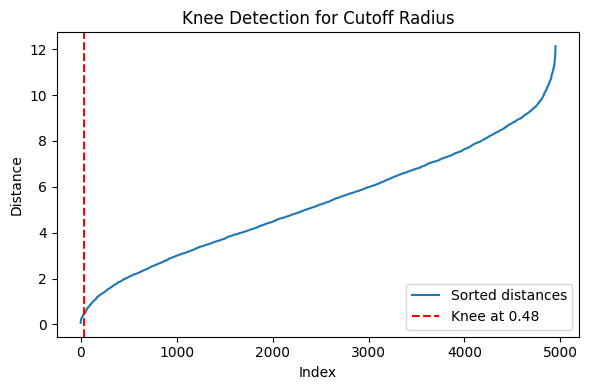

In [37]:
cutoff_dist = find_cutoff_radius(coords, plot=True)

In [48]:
dist_mat = spatial_neighbors(loc_df.values, coord_type='generic', radius=1.5)

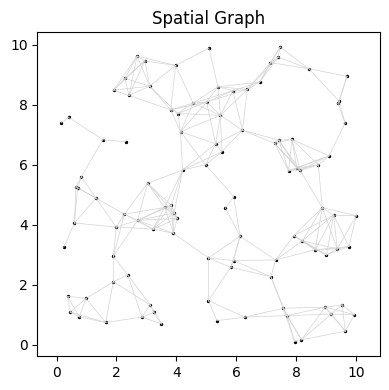

In [49]:
plot_spatial_graph(coords, dist_mat)

In [62]:
edges = get_edge_indices(dist_mat)

In [11]:
import numpy as np
from scipy.stats import norm, poisson

def generate_ligand_receptor_counts(n, rho=0.8, lam1=10, lam2=5):
    """
    Generate ligand and receptor counts per location using a Gaussian copula.
    
    Parameters:
        rho (float): desired correlation
        mean_count (float): mean count for Poisson marginals
    
    Returns:
        ligand_counts (np.ndarray): N array
        receptor_counts (np.ndarray): N array
    """
    
    # Step 1: Sample from bivariate Gaussian
    cov = np.array([[1, rho], [rho, 1]])
    mv_samples = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=n)
    u = norm.cdf(mv_samples[:, 0])
    v = norm.cdf(mv_samples[:, 1])

    # Step 2: Transform to counts (Poisson)
    ligand_counts = poisson.ppf(u, mu=lam1).astype(int)
    receptor_counts = poisson.ppf(v, mu=lam2).astype(int)

    return ligand_counts, receptor_counts


In [12]:
l_array, r_array = generate_ligand_receptor_counts(coords.shape[0])

In [18]:
B = pd.DataFrame(np.vstack([l_array, r_array]).T, columns = ['Ligand', 'Receptor'])

In [25]:
adj_mat = dist_mat.copy()

In [26]:
adj_mat[adj_mat > 0] = 1

In [31]:
adj_mat.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

----------------------
## Run copula correlation

In [83]:
import copula_pois_pois as cpp
import importlib
import itertools
import tqdm

In [260]:
importlib.reload(cpp)

<module 'copula_pois_pois' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/simplified_method/copula_pois_pois.py'>

In [74]:
edges.shape

(274, 2)

In [75]:
x, y = l_array[edges[:,0]], r_array[edges[:,1]]

In [65]:
x_train = np.linspace(-0.99, 0.99, 1000)

In [86]:
cpp.quick_find(x,y)

(-0.11198198198198195, True, -0.07699090034271726)

In [92]:
cpp.quick_find_vectorized(x,y)

(-0.11198198198198195, True, -0.07699090034271726)

## Simulation 

In [165]:
SEED = 42
np.random.seed(SEED)

In [166]:
importlib.reload(cpp)

<module 'copula_pois_pois' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/simplified_method/copula_pois_pois.py'>

In [177]:
n = 1000
lam_x_list = [0.5, 1, 2, 3, 5, 10]
lam_y_list = [0.5, 1, 2, 3, 5, 10]
coeff_list = [-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9]

results = []

for lam_x, lam_y, coeff in tqdm.tqdm(itertools.product(lam_x_list, lam_y_list, coeff_list)):
    df = cpp.sample_from_bivariate_poisson_copula(
        n=n,
        lam_x=lam_x,
        lam_y=lam_y,
        coeff=coeff
    )
    cop_res = cpp.quick_find_vectorized(df.x,df.y)
    results.append({
        'lam_x': lam_x,
        'lam_y': lam_y,
        'coeff_target': coeff,
        'copula': cop_res[0],
        'copula_status': cop_res[1],
        'empirical_corr': cop_res[2]
    })

252it [00:01, 130.40it/s]


In [178]:
results_df = pd.DataFrame(results)

In [179]:
results_df = results_df.loc[results_df.copula_status]

In [180]:
results_df.loc[:, 'copula_abs_err'] = (results_df["copula"] - results_df["coeff_target"]).abs()
results_df.loc[:, 'empirical_abs_err'] = (results_df["empirical_corr"] - results_df["coeff_target"]).abs()

# Count how often empirical is better than copula
copula_wins = (results_df['empirical_abs_err'] > results_df['copula_abs_err']).sum()
total = len(results_df)

print(f"Copula better than empirical in {copula_wins}/{total} cases")
print(f"Mean copula abs error:    {results_df['copula_abs_err'].mean():.4f}")
print(f"Mean empirical abs error: {results_df['empirical_abs_err'].mean():.4f}")


Copula better than empirical in 116/179 cases
Mean copula abs error:    0.0262
Mean empirical abs error: 0.0488


In [181]:
results_df.loc[:, 'copula_err'] = (results_df["copula"] - results_df["coeff_target"])
results_df.loc[:, 'empirical_err'] = (results_df["empirical_corr"] - results_df["coeff_target"])

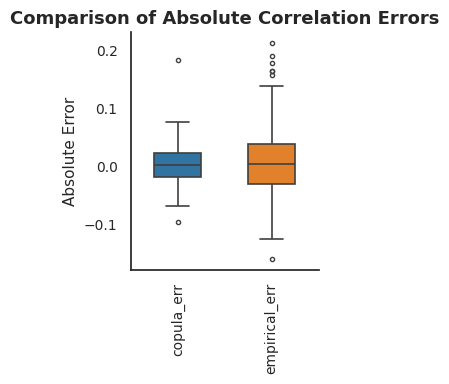

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
plot_df = results_df[["copula_err", "empirical_err"]].melt(
    var_name="Method", value_name="Absolute Error"
)

# Set style
#sns.set(style="white")

# Create figure
plt.figure(figsize=(3, 4))
ax = sns.boxplot(
    data=plot_df,
    x="Method",
    y="Absolute Error",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    linewidth=1.2,
    fliersize=3,
    width=0.5,
    hue='Method'
)

# Improve plot aesthetics
ax.set_title("Comparison of Absolute Correlation Errors", fontsize=13, weight='bold')
ax.set_xlabel("")
ax.set_ylabel("Absolute Error", fontsize=11)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()


## More simulation

In [188]:
n = 1000
lam_x_list = [0.5, 1, 2, 3, 5, 10]
lam_y_list = [0.5, 1, 2, 3, 5, 10]
coeff_list = np.linspace(-0.99, 0.99, 100)

arg_list = []

for lam_x, lam_y, coeff in tqdm.tqdm(itertools.product(lam_x_list, lam_y_list, coeff_list)):
    df = cpp.sample_from_bivariate_poisson_copula(
        n=n,
        lam_x=lam_x,
        lam_y=lam_y,
        coeff=coeff
    )
    x = df.x.to_numpy()
    y = df.y.to_numpy()
    arg_list.append((x, y, lam_x, lam_y, coeff))  # include truth info here

3600it [00:15, 230.75it/s]


In [286]:
def run_copula_estimation(args):
    x, y, lam_x, lam_y, coeff_target = args
    copula_corr, status, emp_corr = cpp.quick_find_vectorized(x, y, skip_local_min=True)
    
    return {
        'lam_x': lam_x,
        'lam_y': lam_y,
        'coeff_target': coeff_target,
        'copula': copula_corr,
        'copula_status': status,
        'empirical_corr': emp_corr
    }


In [287]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=20, verbose=2)(
    delayed(run_copula_estimation)(args) for args in tqdm.tqdm(arg_list)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:05<00:00, 636.75it/s]
[Parallel(n_jobs=20)]: Done 2382 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:    6.1s finished


In [289]:
results_df_all = pd.DataFrame(results)

In [261]:
x,y,lam_x_t,lam_y_t,coeff_target = arg_list[800]

In [268]:
loglikvec = cpp.only_log_pois_pois_lik(
    x,
    y,
    x.mean(),
    y.mean(),
    False
)

In [269]:
peaks, _ = find_peaks(-loglikvec)
max_peak = x_train[peaks[0]]

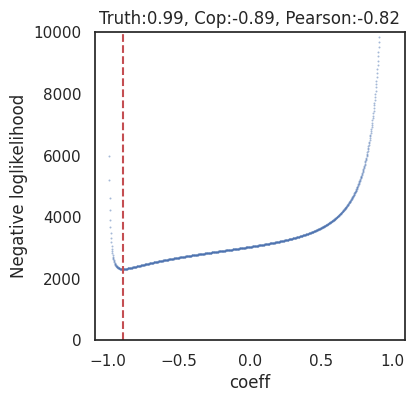

In [271]:
x_train = np.linspace(-0.99, 0.99, 1000)
plt.figure(figsize=(4,4))
plt.scatter(
    x_train,
    loglikvec,
    s=2,
    lw=0,
    alpha=0.5
);
plt.axvline(x=max_peak,c='r',ls='--');
plt.ylim(0,10000)
emp_p = np.corrcoef(x,y)[0,1]
plt.ylabel('Negative loglikelihood')
plt.xlabel("coeff")
plt.title(f"Truth:{coeff:.2f}, Cop:{max_peak:.2f}, Pearson:{emp_p:.2f}");

In [276]:
val = -loglikvec
peaks, _ = find_peaks(val)

In [277]:
peaks

array([50])

In [278]:
cpp.quick_find_vectorized(x,y)

(nan, False, -0.8212889623721851)

In [280]:
from scipy.interpolate import UnivariateSpline
y_spl = UnivariateSpline(x_train, val, s=0, k=4)
y_spl_2d = y_spl.derivative(n=2)
d2l = y_spl_2d(x_train)

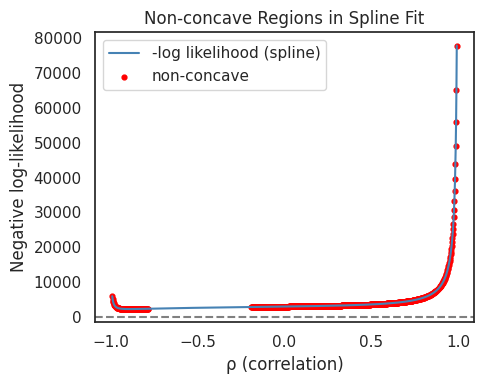

In [285]:
non_concave_idx = np.where(d2l < 0)[0]
non_concave_x = x_train[non_concave_idx]
non_concave_y = val[non_concave_idx]

# Plot the spline and highlight bad regions
plt.figure(figsize=(5, 4))
plt.plot(x_train, -val, color='steelblue', lw=1.5, label='-log likelihood (spline)')
plt.scatter(non_concave_x, -non_concave_y, color='red', s=12, label='non-concave')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title("Non-concave Regions in Spline Fit")
plt.xlabel("ρ (correlation)")
plt.ylabel("Negative log-likelihood")
plt.legend()
plt.tight_layout()
plt.show()

In [292]:
results_df = results_df_all.loc[results_df_all.copula_status]

In [293]:
results_df.shape

(3600, 6)

In [294]:
results_df.loc[:, 'copula_abs_err'] = (results_df["copula"] - results_df["coeff_target"]).abs()
results_df.loc[:, 'empirical_abs_err'] = (results_df["empirical_corr"] - results_df["coeff_target"]).abs()

# Count how often empirical is better than copula
copula_wins = (results_df['empirical_abs_err'] > results_df['copula_abs_err']).sum()
total = len(results_df)

print(f"Copula better than empirical in {copula_wins}/{total} cases")
print(f"Mean copula abs error:    {results_df['copula_abs_err'].mean():.4f}")
print(f"Mean empirical abs error: {results_df['empirical_abs_err'].mean():.4f}")


Copula better than empirical in 2598/3600 cases
Mean copula abs error:    0.0351
Mean empirical abs error: 0.0601


In [295]:
results_df.loc[:, 'copula_err'] = (results_df["copula"] - results_df["coeff_target"])
results_df.loc[:, 'empirical_err'] = (results_df["empirical_corr"] - results_df["coeff_target"])

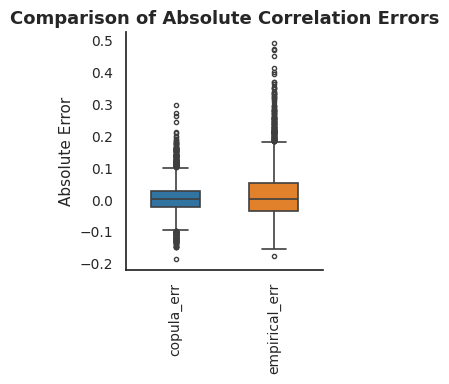

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
plot_df = results_df[["copula_err", "empirical_err"]].melt(
    var_name="Method", value_name="Absolute Error"
)

# Set style
#sns.set(style="white")

# Create figure
plt.figure(figsize=(3, 4))
ax = sns.boxplot(
    data=plot_df,
    x="Method",
    y="Absolute Error",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    linewidth=1.2,
    fliersize=3,
    width=0.5,
    hue='Method'
)

# Improve plot aesthetics
ax.set_title("Comparison of Absolute Correlation Errors", fontsize=13, weight='bold')
ax.set_xlabel("")
ax.set_ylabel("Absolute Error", fontsize=11)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()


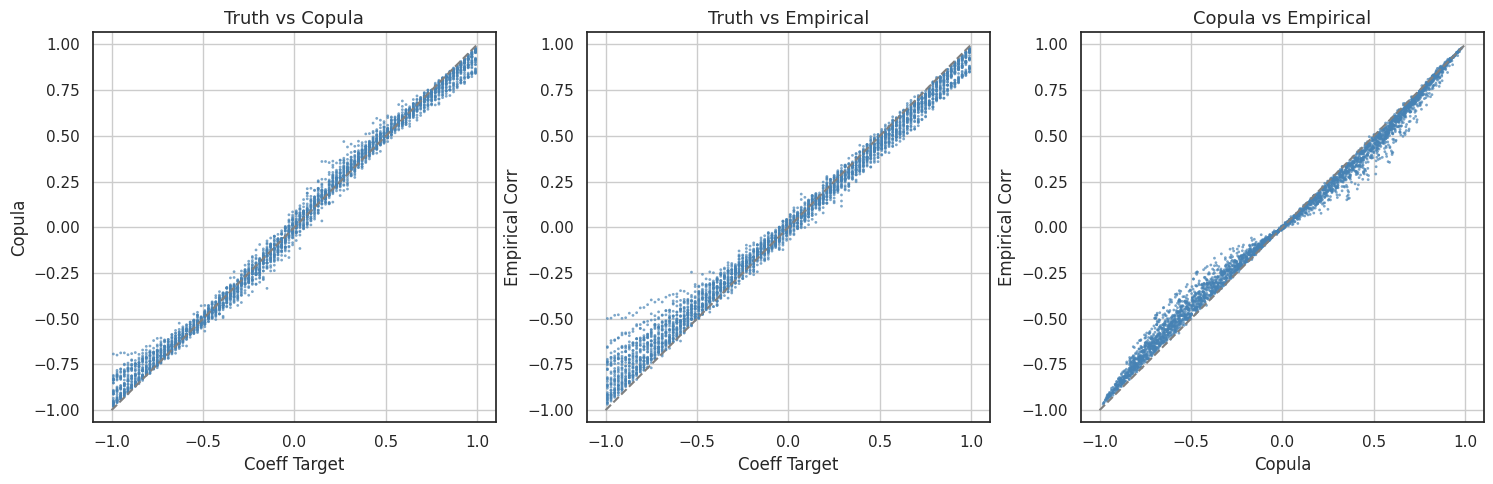

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define column pairs and titles
pairs = [
    ("coeff_target", "copula", "Truth vs Copula"),
    ("coeff_target", "empirical_corr", "Truth vs Empirical"),
    ("copula", "empirical_corr", "Copula vs Empirical"),
]

# Setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot loop without hue/style
for ax, (xcol, ycol, title) in zip(axes, pairs):
    sns.scatterplot(
        data=results_df,
        x=xcol,
        y=ycol,
        ax=ax,
        s=4,
        lw=0,
        alpha=0.7,
        edgecolor='none',
        color='steelblue'
    )
    ax.plot([-1, 1], [-1, 1], linestyle='--', color='gray')
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xcol.replace('_', ' ').title())
    ax.set_ylabel(ycol.replace('_', ' ').title())
    ax.axis("equal")
    ax.grid(True)

plt.tight_layout()
plt.show()


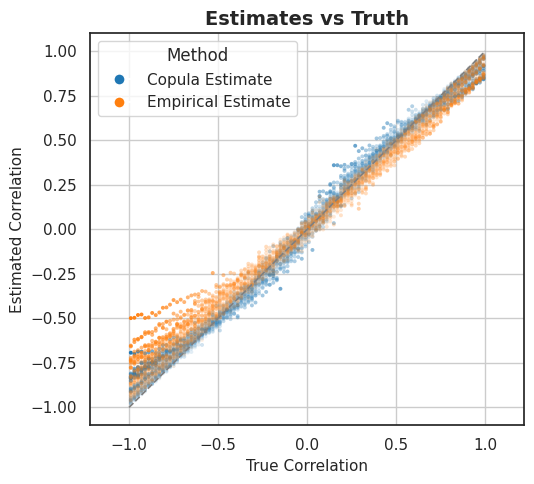

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(5.5, 5))
ax = plt.gca()

# Normalize error for alpha scaling
# Normalize error to [0.1, 1.0], where high error = dark
def normalize_error(err):
    norm = (err - err.min()) / (err.max() - err.min())
    return np.clip(norm, 0.1, 1.0)

copula_alpha = normalize_error(results_df["copula_err"].abs())
empirical_alpha = normalize_error(results_df["empirical_err"].abs())


# Plot Copula
ax.scatter(
    results_df["coeff_target"],
    results_df["copula"],
    s=8,
    lw=0,
    color="#1f77b4",
    alpha=copula_alpha,
    label="Copula Estimate"
)

# Plot Empirical
ax.scatter(
    results_df["coeff_target"],
    results_df["empirical_corr"],
    s=8,
    lw=0,
    color="#ff7f0e",
    alpha=empirical_alpha,
    label="Empirical Estimate"
)

# Reference line
ax.plot([-1, 1], [-1, 1], linestyle='--', color='gray', lw=1.2)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Copula Estimate',
           markerfacecolor='#1f77b4', markersize=8, alpha=1.0),
    Line2D([0], [0], marker='o', color='w', label='Empirical Estimate',
           markerfacecolor='#ff7f0e', markersize=8, alpha=1.0)
]
ax.legend(handles=legend_elements, title="Method", loc='upper left')


# Styling
ax.set_title("Estimates vs Truth", fontsize=14, weight='bold')
ax.set_xlabel("True Correlation", fontsize=11)
ax.set_ylabel("Estimated Correlation", fontsize=11)
ax.grid(True)
ax.axis("equal")
#ax.legend()
plt.tight_layout()
plt.show()


In [303]:
import numpy as np

# Preallocate arrays
sparsity = np.zeros(len(arg_list))
min_mean = np.zeros(len(arg_list))

for i, (x, y, *_rest) in enumerate(arg_list):
    sparsity[i] = ((x == 0).sum() + (y == 0).sum()) / (2 * len(x))
    min_mean[i] = min(np.mean(x), np.mean(y))


In [304]:
results_df.loc[:,"sparsity"] = sparsity[results_df.index]
results_df.loc[:,"min_mean"] = min_mean[results_df.index]

In [305]:
results_df["sparsity_bin"] = pd.cut(
    results_df["sparsity"],
    bins=[-0.001, 0.1, 0.3, 0.6, 1.0],
    labels=["<10%", "10–30%", "30–60%", ">60%"]
)

results_df["min_mean_bin"] = pd.cut(
    results_df["min_mean"],
    bins=[0, 1, 3, 6, 10, np.inf],
    labels=["<1", "1–3", "3–6", "6–10", "10+"]
)


In [306]:
print(results_df["sparsity_bin"].cat.categories)


Index(['<10%', '10–30%', '30–60%', '>60%'], dtype='object')


In [307]:
results_df[['sparsity_bin']].value_counts()

sparsity_bin
<10%            1483
10–30%          1033
30–60%          1014
>60%              70
Name: count, dtype: int64

In [308]:
plot_df = results_df[["copula_err", "empirical_err", "sparsity_bin"]].melt(
    id_vars="sparsity_bin",
    var_name="Method",
    value_name="Absolute Error"
)


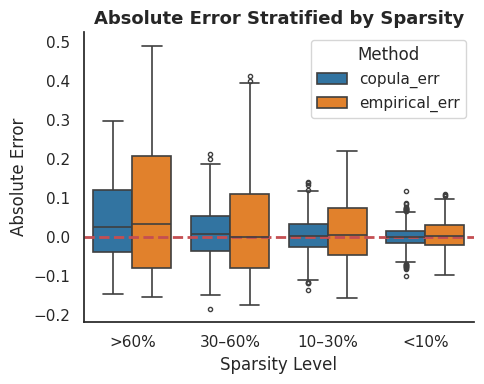

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
ax = sns.boxplot(
    data=plot_df,
    x="sparsity_bin",
    y="Absolute Error",
    hue="Method",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    linewidth=1.2,
    fliersize=3,
    order=[">60%", "30–60%", "10–30%", "<10%"]  # reversed order
)

ax.set_title("Absolute Error Stratified by Sparsity", fontsize=13, weight='bold')
ax.set_xlabel("Sparsity Level")
ax.set_ylabel("Absolute Error")
plt.axhline(y=0,c='r',ls='--',lw=2)
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()


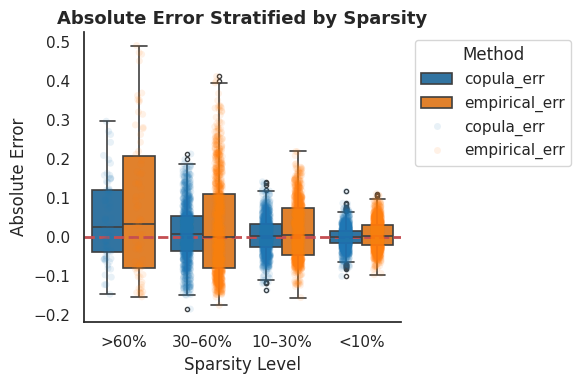

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))

# Base boxplot
ax = sns.boxplot(
    data=plot_df,
    x="sparsity_bin",
    y="Absolute Error",
    hue="Method",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    linewidth=1.2,
    fliersize=3,
    order=[">60%", "30–60%", "10–30%", "<10%"]
)

# Overlay stripplot to show individual points
sns.stripplot(
    data=plot_df,
    x="sparsity_bin",
    y="Absolute Error",
    hue="Method",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    dodge=True,
    alpha=0.1,
    jitter=True,
    marker='o',
    linewidth=0,
    order=[">60%", "30–60%", "10–30%", "<10%"],
    ax=ax
)

# Final touches
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_title("Absolute Error Stratified by Sparsity", fontsize=13, weight='bold')
ax.set_xlabel("Sparsity Level")
ax.set_ylabel("Absolute Error")
plt.xticks(rotation=0)
sns.despine()
plt.legend(title="Method", bbox_to_anchor=(1.02, 1), loc='upper left')  # one legend
plt.tight_layout()
plt.show()


In [311]:
plot_df = results_df[["copula_err", "empirical_err", "min_mean_bin"]].melt(
    id_vars="min_mean_bin",
    var_name="Method",
    value_name="Absolute Error"
)


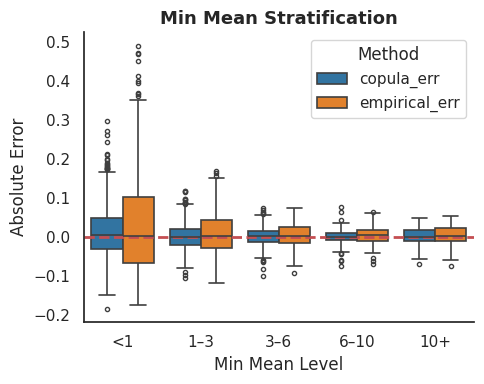

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
ax = sns.boxplot(
    data=plot_df,
    x="min_mean_bin",
    y="Absolute Error",
    hue="Method",
    palette={"copula_err": "#1f77b4", "empirical_err": "#ff7f0e"},
    linewidth=1.2,
    fliersize=3
)

ax.set_title("Min Mean Stratification", fontsize=13, weight='bold')
ax.set_xlabel("Min Mean Level")
ax.set_ylabel("Absolute Error")
plt.axhline(y=0,c='r',ls='--',lw=2)
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()


In [313]:
results_df.shape

(3600, 14)